# Description du TP

Pour ce TP de deep learning, nous allons utiliser un réseau existant ([UNET](https://fr.wikipedia.org/wiki/U-Net)) et le jeu de données [Vaihingen](https://www2.isprs.org/commissions/comm2/wg4/benchmark/2d-sem-label-vaihingen/).

Dans un premier temps, [téléchargez](https://drive.google.com/file/d/1GaGCF3natHMlbn7KXrkaEPjWTmAJ6zEW/view?usp=sharing) et décompressez les données puis ajoutez les à votre Google Drive (à la racine si possible). Vous devrez avoir environ 1.5/2Go de libre.

Si vous avez une connexion lente, lancez les commandes ci-dessous, cela téléchargera les données en local sur votre session Google Colab. Vous pourrez ensuite les glisser dans votre drive par glisser déposer.

Tout le long de ce TP, des concepts seront abordés et redigeront vers des explications que je vous invite fortement à lire et à comprendre.

Pour toute question : romain.wenger[at]live-cnrs.unistra.fr

In [10]:
!pip install -U --no-cache-dir gdown --pre

  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6


In [1]:
import gdown
import zipfile

url = 'https://drive.google.com/uc?id=1GaGCF3natHMlbn7KXrkaEPjWTmAJ6zEW'
output = 'dataset.zip'
gdown.download(url, output, quiet=False)

with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall('.')

Downloading...
From (original): https://drive.google.com/uc?id=1GaGCF3natHMlbn7KXrkaEPjWTmAJ6zEW
From (redirected): https://drive.google.com/uc?id=1GaGCF3natHMlbn7KXrkaEPjWTmAJ6zEW&confirm=t&uuid=e6d54a18-7321-4668-8d43-238af5b7fdf6
To: /content/dataset.zip
100%|██████████| 1.15G/1.15G [00:27<00:00, 41.0MB/s]


# Installation des packages et importations


Nous utilisons une surcouche, [*segmentation-models*](https://github.com/qubvel/segmentation_models), permettant l'utilisation de [réseaux préentrainés](https://towardsdatascience.com/transfer-learning-from-pre-trained-models-f2393f124751) afin d'améliorer les résultats de classification.

In [2]:
!pip install segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.0 MB/s eta 0:00:00


In [4]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input
from keras.layers import Convolution2D
from keras.layers import Activation, Reshape
from keras.layers import BatchNormalization
from keras import backend as K
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

import numpy as np
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
import tifffile as tiff
import math
import os
import random
from random import shuffle
import matplotlib.pyplot as plt
from random import randint
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from random import randrange

#Si l'import de segmentation_models plante, relancez le runtime et cette cellule

env: SM_FRAMEWORK=tf.keras


# Prétraitement des données

## Méthodes cachées

Méthodes complexes que vous n'avez pas besoin de développer vous même. Vous trouverez néanmoins ci-dessous une explication de leur utilisation.

In [2]:
#Methode permettant d'effectuer aléatoirement une technique d'augmentation de données pour éviter l'overfitting
def data_augmentation(patch_img, patch_mask):
    random_transformation = np.random.randint(1,5)
    if random_transformation == 1:
        patch_img = patch_img.transpose([1,0,2])
        patch_mask = patch_mask
    elif random_transformation == 2:
        patch_img = np.rot90(patch_img, 1)
        patch_mask = np.rot90(patch_mask, 1)
    elif random_transformation == 3:
        patch_img = np.rot90(patch_img, 2)
        patch_mask = np.rot90(patch_mask, 2)
    elif random_transformation == 4:
        patch_img = np.rot90(patch_img, 3)
        patch_mask = np.rot90(patch_mask, 3)
    else:
        pass

    return patch_img, patch_mask

palette = {0 : (255, 255, 255), # Surface imperméable (blanc)
           1 : (0, 0, 255),     # Batiment (bleus)
           2 : (0, 255, 255),   # Végétation basse (cyan)
           3 : (0, 255, 0),     # Arbre (vert)
           4 : (255, 255, 0),   # Voiture (jaune)
           5 : (255, 0, 0),     # Clutter (rouge)
           6 : (0, 0, 0)}       # Indéfini (noir)
invert_palette = {v: k for k, v in palette.items()}

#Methode pour convertir une matrice 2D classifiée vers une matrice 3D RGB
def convert_to_color(arr_2d, palette=palette):
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i

    return arr_3d

#Methode pour convertir une matrice 3D RGB vers une matrice 2D
def convert_from_color(arr_3d, palette=invert_palette):
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    for c, i in palette.items():
        m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
        arr_2d[m] = i

    return arr_2d

## A vous de jouer !

C'est à votre tour ! Lisez bien les instructions avant de commencer et n'ayez pas peur de tester (même si ça ne fonctionne pas !) ;)

L'objectif de cette partie est de fournir des fonctions et des traitements permettant d'extraire un ensemble d'imagettes (de taille 256x256) de train/validation, les normaliser et les transformer sous forme de tenseurs. Nous conserverons une image (qui n'est pas présente dans le jeu de train ni dans le jeu de validation) à des fins de test.



On initialise nos constantes :

*   le chemin vers le dossier sur votre *drive* que vous avez téléchargé
*   le dossier contenant les vérités
*   le dossier contenant les images
*   le dossier contenant les DSM (Digital Surface Model, à ne pas confondre avec Digital Terrain Model)
*   la palette des couleurs
*   la palette des couleurs inversée


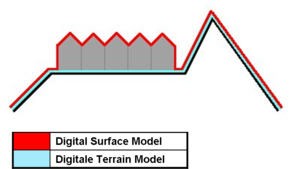




In [ ]:
#Ajouter les fichiers sur votre Google Drive
PATH_GOOGLE_DRIVE = '/content/ISPRS_semantic_labeling_Vaihingen'
FOLDER_GT = 'gts_for_participants'
FOLDER_IMG = 'top'
FOLDER_DSM = 'dsm'
palette = {0 : (255, 255, 255), # Surface imperméable (blanc)
           1 : (0, 0, 255),     # Batiment (bleus)
           2 : (0, 255, 255),   # Végétation basse (cyan)
           3 : (0, 255, 0),     # Arbre (vert)
           4 : (255, 255, 0),   # Voiture (jaune)
           5 : (255, 0, 0),     # Clutter (rouge)
           6 : (0, 0, 0)}       # Indéfini (noir)
invert_palette = {v: k for k, v in palette.items()}

Pour cette partie, il faut séparer les images d'entrainement, de validation et de test. Nous ne prendrons qu'une image de test. Plusieurs implémentations sont possibles pour cette partie. Nous souhaitons avoir deux listes (train et valid) contenant le nom des images. N'oubliez pas d'extraire une image qui sera l'image de test. 60% des images restantes seront pour le jeu de train et 40% pour la validation.

Je vous invite à lire et comprendre les methodes de [*slicing*](https://zestedesavoir.com/tutoriels/582/les-slices-en-python/) en python avant de démarrer le TP.

In [ ]:
#On liste l'ensemble des images vérité (Ground Truth) dans le dossier. Pour construire un chemin, utiliser os.path.join
list_of_files = os.listdir(...)
#On melange aleatoirement la liste, utiliser la méthode shuffle (https://www.w3schools.com/python/ref_random_shuffle.asp)
...

#On extrait la derniere image de la liste, elle sera notre image de test : utiliser pop (https://www.programiz.com/python-programming/methods/list/pop)
TEST_FILE = ...
#Vous n'aurez donc pas forcément tous la même image de test

print('Nom de l\'image de test : ' + TEST_FILE)

#On compte le nombre d'image dans la liste (nb_file) et on extrait le nombre d'images que contiendra le jeu train (60% de la liste, variable nb_train) et le jeu validation (40% de la liste, variable nb_valid)
nb_file = ...
nb_train = int(... * (.../100))
nb_valid = ...

print('\n')
print('Nb d\'images dans la liste : ' + ...)
print('Nb d\'images pour le jeu de train : ' + ...)
print('Nb d\'images pour le jeu de validation : ' + ...)

#On extrait les nb_valid dernieres images de la liste list_of_files
#Slicing
list_valid = list_of_files[nb_train:...+...]
list_train = list_of_files[0:nb_train]

#On affiche les listes train et valid
print('\n')
print('Liste validation :\n' + ...)
print('Liste train :\n' + ...)

Affichez sur un graphique une image aléatoire de la liste. Pour cela, on génère un entier aléatoire compris entre 0 et la taille de la liste - 1. Voila ce à quoi cela doit ressembler :

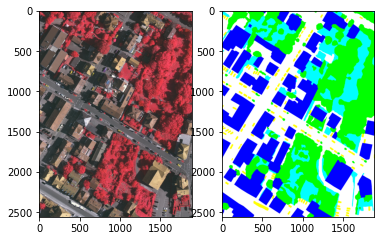

In [ ]:
#Séléction aléatoire de l'indice d'une image dans la liste
indice_img = random.randint(...)
#Chemin vers l'image et sa vérité
path_img_example = os.path.join(PATH_GOOGLE_DRIVE, FOLDER_IMG, ...)
path_gt_example = os.path.join(PATH_GOOGLE_DRIVE, FOLDER_GT, ...)
#On lit l'image avec la fonction de Matplotlib
img = plt.imread(...)
gt = plt.imread(...)

#Utilisez mathplotlib pour l'affichage : à gauche l'image infrarouge couleur et à droite la vérité terrain.
#N'hésitez pas à chercher sur Google comment afficher deux images les unes à côté des autres avec mathplotlib/pyplot
...

#On affiche la taille des images
print('Dimension de l\'image : ' + ...)
print('Dimension de la vérité : ' + ...)

Partie la plus complexe du TP. Il s'agit de préparer nos imagettes (patchs) d'entrainement et de validation. Voici les paramètres de la méthode générant des imagettes (patchs) :
*   Le chemin vers le dossier contenant les données de vérité terrain
*   Le chemin vers le dossier contenant les données images
*   Le nombre d'imagettes (patchs) à créer
*   La liste avec le nom des images de train/validation

En sortie, la fonction renvoie deux listes avec les patchs images et les patchs vérité associés.

L'idée est de séléctionner aléatoirement des imagettes de 256x256 dans notre liste d'images d'entrainement.

Nous avons 7 classes pour notre vérité (Surface imperméable, Batiment, Végétation basse, Arbre, Voiture, Clutter, Indéfini) et 3 bandes pour notre image (Bleu, Vert, Rouge). En segmentation sémantique, un réseau de convolution attend en entrée une bande binaire (1 et 0) par classe étudiée. Pour 7 classes, il faudra alors redimensionner notre vérité afin d'obtenir une bande par classe. Pour l'instant la dimension de nos images vérité est (x, y, 3) et nous souhaitons obtenir des imagettes vérité de (256, 256, 7). Les patchs images ne changent pas de dimension en z, ils conservent leurs 3 bandes pour une dimension après sélection de (256, 256, 3).
En revanche, les patchs images doivent être [normalisés](https://dataanalyticspost.com/Lexique/normalisation/) (valeur proches de 0) pour une meilleure classification. Pour faire simple dans le cadre de ce tp, nous diviserons chaque bande par 255 pour obtenir une plage de valeur entre 0 et 1.

N'hésitez pas à vérifier le shape des imagettes (patchs) que vous produisez pour comprendre notamment le fonctionnement des méthodes cachées.





In [ ]:
#Methode pour générer les patchs d'entrainement et de validation
#Note : attention au typage des données, qui peut, si mal géré, remplir l'espace mémoire rapidement
def generate_learning_patches(path_folder_gt, path_folder_img, nb_patches, size_patches, list_with_filename, data_aug = False):
  #Compteur du nombre d'images
  _current_nb = 0
  #Liste des patchs images et vérités
  X_res = list()
  Y_res = list()

  #On boucle sur le nombre de patchs créés
  while _current_nb < nb_patches:
    #Index aléatoire pour selectionner un fichier dans les listes
    i = random.randint(0, ...)
    #On extrait les chemins vers les images
    _gt_path = os.path.join(path_folder_gt, list_with_filename[i])
    _img_path = os.path.join(path_folder_img, list_with_filename[i])

    #On lit les images verites et orthophotos
    #Pour la vérité, un entier non signé sur 1 octet suffit amplement
    _gt = tiff.imread(...).astype('uint8')
    _img = tiff.imread(...).astype('float16')

    #On choisit des coordonnées aléatoire dans l'image (attention aux bords de l'image !)
    _y = random.randint(0, ...)
    _x = random.randint(0, ...)

    #On selectionne les patchs orthophotos et verites dans les images -> on prend la coordonné précédente et on ajoute la taille du patch
    #Indice : slicing
    res_gt = ...
    res_img = ...

    #On normalise chacune des bandes en divisant par 255 pour avoir des valeurs comprises entre 0 et 1 -> 255 étant la valeur maximale pour chacune des bandes
    for b in range(0, ...):
      res_img[:,:,b] = ...

    #On convertit les patchs vérités -> regardez le code dans les fonctions cachées pour comprendre ce qu'on obtient en sortie
    res_gt = convert_from_color(res_gt)

    #On creer notre matrice zero de profondeur 7 (correspondant au nombre de classe) que l'on va remplir par la suite
    _tmp_gt = np.zeros( ... , dtype=np.uint8)

    #On boucle sur nos 7 classes (0 à 6) et on binarise avant de l'ajouter à la bande correspondante de notre matrice nulle
    for i in range(0, 7):
      _tmp_gt[:, :, i] = np.where(... , ... , ...)

    #Glitch pour économiser de la mémoire
    #res_gt = _tmp_gt
    #_tmp_gt = None

    #On ajoute nos patchs aux listes correspondantes et on convertit avec le meilleur type de données
    X_res.append(...) #convertir en np.float16
    Y_res.append(...) #convertir en uint8 (entier non signé sur 1 octet)

    #On incrémente notre compteur du nombre de patchs
    _current_nb += 1

    #On applique nos méthodes d'augmentation de données sur notre patch image et vérité
    if data_aug:
      if randrange(100) <= 25:
        res_img, res_gt = data_augmentation(res_img, res_gt)
        X_res.append(res_img.astype(np.float16))
        Y_res.append(res_gt.astype('uint8'))
        _current_nb += 1

  #On renvoie les deux listes que l'on convertit en array numpy
  return np.array(...), np.array(...)

Ci-dessous, vous trouverez les paramètres afin de lancer la fonction de création des patchs.



In [ ]:
#Génération des imagettes (patchs) pour l'entrainement et la validation
path_folder_gt = os.path.join(PATH_GOOGLE_DRIVE, FOLDER_GT)
path_folder_img = os.path.join(PATH_GOOGLE_DRIVE, FOLDER_IMG)
nb_patches_valid = 120
nb_patches_train = 1200
size_patches = 256

X_train, Y_train = generate_learning_patches(path_folder_gt, path_folder_img, nb_patches_train, size_patches, list_train, data_aug = True)
X_valid, Y_valid = generate_learning_patches(path_folder_gt, path_folder_img, nb_patches_valid, size_patches, list_valid, data_aug = False)

# Apprentissage

## Méthodes cachées

Méthodes complexes que vous n'avez pas besoin de développer vous même. Vous trouverez néanmoins ci-dessous une explication de leur utilisation.

In [ ]:
def dice(y_true, y_pred, smooth=1.):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

## A vous de jouer !

C'est à votre tour ! Lisez bien les instructions avant de commencer et n'ayez pas peur de tester ;)

VGG16 est utilisé comme [*backbone*](https://stackoverflow.com/questions/59868132/what-means-backbone-in-a-neural-network) et des poids préajustés sur [ImageNet](https://fr.wikipedia.org/wiki/ImageNet).

Quelle est la fonction d'activation répondant le mieux à notre problématique et pourquoi ?

Completez la fonction d'activation, le nombre de classe et la taille de nos imagettes (patchs).

In [ ]:
model = sm.Unet('vgg16', classes=7, activation='softmax', input_shape=(size_patches, size_patches, 3), encoder_weights='imagenet')

Nous souhaitons ensuite compiler le modèle en utilisant comme optimizer Adam avec un *learning rate* de 1 x 10^-4, une entropie croisée pour la *loss* et la précision et la [*dice*](https://fr.wikipedia.org/wiki/Indice_de_S%C3%B8rensen-Dice) comme métriques d'évaluation.

L'entrainement prendra 40/50 min environ. Completez le code et faites en sorte qu'il fonctionne. Par la suite, nous utiliserons les poids d'un réseau déjà entrainé sur nos images.

N'hésitez pas à jeter un oeil à la [documentation](https://faroit.com/keras-docs/1.2.0/).

In [ ]:
model.compile(optimizer = Adam(lr = 1e-4), loss = 'categorical_crossentropy', metrics = [dice, 'accuracy'])

Quel problème voyez-vous dans l'utilisation de l'accuracy ? Est-ce une métrique fiable pour notre cas d'étude ? Pourquoi est-il préférable d'utiliser la [*dice*](https://fr.wikipedia.org/wiki/Indice_de_S%C3%B8rensen-Dice) ou encore l'[*IoU*](https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/) ? Allez voir cette [page](https://sci2s.ugr.es/keel/imbalanced.php) pour obtenir un indice.

Ici nous initialison des *callbacks*:


*   L'*early stopping* permet au réseau de s'arrêter X *epochs* après détection d'un [*overfitting*](https://fr.wikipedia.org/wiki/Surapprentissage).
*   *Reduce LR* permet de réduire de *learning rate* (loss dans notre cas) lorsqu'une métrique a cessé de s'améliorer.
*   *Model Checkpoint* sauvegarde les poids du modèle tous les epochs. Cela permet de les avoir en local pour prédire sans avoir à réentrainer un modèle.






In [ ]:
#On sauvegarde nos poids à la racine
PATH_WEIGHTS = './weights_model.hdf5'

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, min_lr=0.00001)
model_checkpoint = ModelCheckpoint(PATH_WEIGHTS, monitor='val_loss', save_best_only=True)

On lance l'entrainement du modèle. En vous fiant à la documentation de Keras, complétez la fonction avec les données d'entrainement (imagettes et vérités), de validation (imagettes et vérités), une taille de *batch* de 64, 100 *epochs* et la liste des trois *callbacks* prédécents.

In [ ]:
model.fit(
   x=...,
   y=...,
   batch_size=...,
   epochs=...,
   callbacks = ..., #ajouter les callbacks sous forme de liste
   validation_data=... #ajouter un tuple contenant les donnes de valisation (x et y)
)

# Prédiction et évaluation

## Méthodes cachées

Méthodes complexes que vous n'avez pas besoin de développer vous même. Vous trouverez néanmoins ci-dessous une explication de leur utilisation.

In [ ]:
#Méthode permetant de prédire sur une imagette de taille patch_sz
def predict(x, model, patch_sz=256, n_classes=7):
	img_height = x.shape[0]
	img_width = x.shape[1]
	n_channels = x.shape[2]
	# make extended img so that it contains integer number of patches
	npatches_vertical = math.ceil(img_height / patch_sz)
	npatches_horizontal = math.ceil(img_width / patch_sz)
	extended_height = patch_sz * npatches_vertical
	extended_width = patch_sz * npatches_horizontal
	ext_x = np.zeros(shape=(extended_height, extended_width, n_channels), dtype=np.float32)
	# fill extended image with mirrors:
	ext_x[:img_height, :img_width, :] = x
	for i in range(img_height, extended_height):
		ext_x[i, :, :] = ext_x[2 * img_height - i - 1, :, :]
	for j in range(img_width, extended_width):
		ext_x[:, j, :] = ext_x[:, 2 * img_width - j - 1, :]

	# now we assemble all patches in one array
	patches_list = []
	for i in range(0, npatches_vertical):
		for j in range(0, npatches_horizontal):
			x0, x1 = i * patch_sz, (i + 1) * patch_sz
			y0, y1 = j * patch_sz, (j + 1) * patch_sz
			patches_list.append(ext_x[x0:x1, y0:y1, :])
	# model.predict() needs numpy array rather than a list
	patches_array = np.asarray(patches_list)
	# predictions:
	patches_predict = model.predict(patches_array, batch_size=60)
	prediction = np.zeros(shape=(extended_height, extended_width, n_classes), dtype=np.float32)
	for k in range(patches_predict.shape[0]):
		i = k // npatches_horizontal
		j = k % npatches_vertical
		x0, x1 = i * patch_sz, (i + 1) * patch_sz
		y0, y1 = j * patch_sz, (j + 1) * patch_sz
		prediction[x0:x1, y0:y1, :] = patches_predict[k, :, :, :]
	return prediction[:img_height, :img_width, :]

#Méthode permettant d'obtenir une prédiction à partir du masque contenant les probabilités par bande
def get_prediction_from_mask(mask, n_classes):
	res = np.zeros((mask.shape[0], mask.shape[1]), dtype=int)

	for x in range(0, mask.shape[0]):
		for y in range(0, mask.shape[1]):
			band_nb_max = 0
			_tmp_max_value = 0
			for b in range(0, n_classes):
				if mask[x, y, b] > _tmp_max_value:
					_tmp_max_value = mask[x, y, b]
					band_nb_max = b
			res[x, y] = band_nb_max

	return res

#Méthode permettant d'afficher une matrice de confusion
def save_confusion_matrix(cm, classes, saveAsPng = True, pathToSave = None, normalize=True, title='Matrice de confusion', cmap=plt.cm.Blues):
	"""
	This function prints and plots the confusion matrix.
	Normalization can be applied by setting `normalize=True` (default).
	"""
	if normalize:
		cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

	plt.imshow(cm, interpolation='nearest', cmap=cmap)
	plt.title(title)
	plt.colorbar()
	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation=45)
	plt.yticks(tick_marks, classes)

	fmt = '.2f' if normalize else 'd'
	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, format(cm[i, j], fmt),
				 horizontalalignment="center",
				 color="white" if cm[i, j] > thresh else "black")

	plt.figure(figsize = (15,10))
	plt.ylabel('Verite')
	plt.xlabel('Prediction')
	plt.tight_layout()
	#plt.savefig('./cm_test_set.png')
	plt.show()

## A vous de jouer !

C'est à votre tour ! Lisez bien les instructions avant de commencer et n'ayez pas peur de tester ;)

Nous souhaitons charger les poids du modèle et prédire sur une imagette aléatoire (un patch) de 256px par 256px sur notre grande image de test.

In [ ]:
#On charge les poids que je vous ai transmis, remplacez le chemin par les votres si vous avez pu entrainer un nouveau modèle
model.load_weights('/content/drive/MyDrive/ISPRS_semantic_labeling_Vaihingen/weights_model.hdf5')

Voici l'image devant être utilisée pour les tests en prenant les poids fournis : top_mosaic_09cm_area7.tif
Si vous avez décidé d'entrainer le modèle vous-même, choisissez l'imagette selectionnée plus haut lors de la phase de prétraitement.
N'oubliez pas de normaliser l'imagette (le patch) avant de prédire (on divise par 255) !

In [ ]:
#Je ne donne pas plus d'indications ici, essayez de prédire sur une zone aléatoire dans l'image de la taille d'un patch :
img_m = tiff.imread('/content/drive/MyDrive/ISPRS_semantic_labeling_Vaihingen/top/top_mosaic_09cm_area7.tif').astype(int)
x = randint(0, ...)
y = randint(0, ...)
pred_test = predict(... , model, patch_sz=size_patches, n_classes=...)
pred_final = get_prediction_from_mask(pred_test, 7)
res = convert_to_color(pred_final)

#Ici nous souhaitons avoir la portion d'image correspondante pour comparer visuellement. Si vous souhaitez, affichez aussi par vous même la vérité terrain
img_output = ...

f, axarr = plt.subplots(1,2)
axarr[0].imshow(img_output)
axarr[1].imshow(res)

On va ensutie calculer une matrice de confusion et un rapport contenanant plusieurs autres métriques par classe. Quelles sont les classes obtenant les meilleurs résultats de classification ? Quelles sont les classes obtenant les moins bons résultats de classification ? Pourquoi ?

In [ ]:
#Ici on cherche le chemin de notre vérité terrain qu'on converti en int
gt = tiff.imread('/content/drive/MyDrive/ISPRS_semantic_labeling_Vaihingen/gts_for_participants/top_mosaic_09cm_area7.tif').astype(int)

size_x = img_m.shape[0]
size_y = img_m.shape[1]
_tmp_x = 0
_tmp_y = 0
y_true = []
y_pred = []

while _tmp_y + size_patches < size_y:
  while _tmp_x + size_patches < size_x:
    _patch = ...
    _patch_gt = ...

    pred = predict(..., model, patch_sz=size_patches, n_classes=...)
    pred = get_prediction_from_mask(pred, 7)

    _patch_gt = convert_from_color(_patch_gt)

    #Flatten permet de passer d'une matrice 2D à une liste 1D. N'hésitez pas à mettre des print pour mieux comprendre
    y_pred = y_pred + list(pred.flatten())
    y_true = y_true + list(_patch_gt.flatten())

    _tmp_x += size_patches

  _tmp_x = 0
  _tmp_y += size_patches

cm = confusion_matrix(y_true, y_pred)
cr = classification_report(y_true, y_pred)
save_confusion_matrix(cm, [0,1,2,3,4])
#Affichez ensuite le rapport de classification et la matrice de confusion

AttributeError: 'ellipsis' object has no attribute 'shape'

Quel est le problème de ce code ? Est-ce que nous évaluons correctement toute l'image ? Que faudrait-il faire pour le perfectionner ?

Essayez ensuite de tester plusieurs paramètres :


*   Lancer des apprentissages avec un nombre d'epoch fixe sans early stopping (5, 10, 20, 30 ...) et constater la différence dans les classifications
*   Lancer des runs avec un réseau non préentrainé (partie "Pour aller plus loins") et comparer les deux approches
*   Ajouter le [NDVI](https://www.dronesimaging.com/wp-content/uploads/2013/05/documentation/indice%20de%20v%C3%A9g%C3%A9tation%20NDVI.pdf) à l'ensemble des bandes et évaluer les prédictions
*   Calculer l'[entropie](https://www.orfeo-toolbox.org/CookBook/Applications/app_HaralickTextureExtraction.html) (basé sur le NDVI par exemple) et l'ajouter en tant que nouvelle bande



# Pour aller plus loin

Ci-dessous une fonction contenant un UNET qui sera cette fois non préentrainé. Je vous propose de l'utiliser afin de comparer les deux approches et ainsi montrer l'utilité des réseaux préentrainés et ce même pour la classification de l'occupation des sols à partir de l'imagerie satellitaire. Si vous souhaitez, vous pouvez utiliser la surcouche [*segmentation-models*](https://github.com/qubvel/segmentation_models) vue précédemment.

In [ ]:
def unet(im_sz=160, n_channels=10, n_classes=4, base=4, weights = [0.5, 1, 1.5, 1.5, 4, 4, 0.5], model_name='unet'):

    droprate=0.4
    kernel_site = (3, 3)

    if n_classes == 1:
        loss = 'binary_crossentropy'
        final_act = 'sigmoid'
    elif n_classes > 1:
        loss = 'categorical_crossentropy'
        final_act = 'softmax'

    b = base
    i = Input((im_sz, im_sz, n_channels))

    c1 = Conv2D(2**b, kernel_site, activation='relu', kernel_initializer='he_normal', padding='same') (i)
    #Le dropout permet de limiter l'overfitting
    c1 = Dropout(droprate) (c1)
    c1 = Conv2D(2**b, kernel_site, activation='relu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(2**(b+1), kernel_site, activation='relu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(droprate) (c2)
    c2 = Conv2D(2**(b+1), kernel_site, activation='relu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(2**(b+2), kernel_site, activation='relu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(droprate) (c3)
    c3 = Conv2D(2**(b+2), kernel_site, activation='relu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(2**(b+3), kernel_site, activation='relu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(droprate) (c4)
    c4 = Conv2D(2**(b+3), kernel_site, activation='relu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(2**(b+4), kernel_site, activation='relu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(droprate) (c5)
    c5 = Conv2D(2**(b+4), kernel_site, activation='relu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(2**(b+3), (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(2**(b+3), kernel_site, activation='relu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(droprate) (c6)
    c6 = Conv2D(2**(b+3), kernel_site, activation='relu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(2**(b+2), (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(2**(b+2), kernel_site, activation='relu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(droprate) (c7)
    c7 = Conv2D(2**(b+2), kernel_site, activation='relu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(2**(b+1), (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(2**(b+1), kernel_site, activation='relu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(droprate) (c8)
    c8 = Conv2D(2**(b+1), kernel_site, activation='relu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(2**b, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(2**b, kernel_site, activation='relu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(droprate) (c9)
    c9 = Conv2D(2**b, kernel_site, activation='relu', kernel_initializer='he_normal', padding='same') (c9)

    o = Conv2D(n_classes, (1, 1), activation='softmax') (c9)

    #Categorical crossentropy pondérée -> on affecte un poids plus important à la classe la moins représentée
    #Pour ajuster au mieux les poids, affichez un graphique avec la répartition des classes dans les images et trouvez unr formule pour l'attribution des poids
    #Sinon, vous pouvez toujours utiliser une loss classique 'categorical_crossentropy'
    def weighted_categorical_crossentropy(weights):
        # weights = [0.9,0.05,0.04,0.01]
        def wcce(y_true, y_pred):
            Kweights = K.constant(weights)
            if not tf.is_tensor(y_pred):
              y_pred = K.constant(y_pred)
            y_true = K.cast(y_true, y_pred.dtype)
            return K.categorical_crossentropy(y_true, y_pred) * K.sum(y_true * Kweights, axis=-1)
        return wcce

    model = Model(inputs=i, outputs=o, name=model_name)
    model.compile(optimizer='sgd',
                  loss=weighted_categorical_crossentropy(weights),
                  metrics=[dice, 'accuracy'])

    return model

# Solutions

## Prétraitements

In [5]:
#Ajouter les fichiers sur votre Google Drive
PATH_GOOGLE_DRIVE = '/content/drive/MyDrive/ISPRS_semantic_labeling_Vaihingen'
FOLDER_GT = 'gts_for_participants'
FOLDER_IMG = 'top'
FOLDER_DSM = 'dsm'
palette = {0 : (255, 255, 255), # Surface imperméable (blanc)
           1 : (0, 0, 255),     # Batiment (bleus)
           2 : (0, 255, 255),   # Végétation basse (cyan)
           3 : (0, 255, 0),     # Arbre (vert)
           4 : (255, 255, 0),   # Voiture (jaune)
           5 : (255, 0, 0),     # Clutter (rouge)
           6 : (0, 0, 0)}       # Indéfini (noir)
invert_palette = {v: k for k, v in palette.items()}

In [6]:
#On liste l'ensemble des images vérité (Ground Truth) dans le dossier
list_of_files = os.listdir(os.path.join(PATH_GOOGLE_DRIVE, FOLDER_GT))
#On melange aleatoirement la liste
shuffle(list_of_files)

#On extrait la derniere image de la liste, elle sera notre image de test
TEST_FILE = list_of_files.pop()

print('Nom de l\'image de test : ' + TEST_FILE)

#On compte le nombre d'image dans la liste et on extrait le nombre d'images que contiendra le jeu train (60%) et le jeu validation (40%)
nb_file = len(list_of_files)
nb_train = int(nb_file * (60/100))
nb_valid = nb_file - nb_train

print('\n')
print('Nb d\'images dans la liste : ' + str(nb_file))
print('Nb d\'images pour le jeu de train : ' + str(nb_train))
print('Nb d\'images pour le jeu de validation : ' + str(nb_valid))

#On extrait les nb_valid dernieres images de la liste list_of_files
list_valid = list_of_files[nb_train:nb_train+nb_valid]
list_train = list_of_files[0:nb_train]

print('\n')
print('Liste validation :\n' + str(list_valid))
print('Liste train :\n' + str(list_train))

Nom de l'image de test : top_mosaic_09cm_area26.tif


Nb d'images dans la liste : 15
Nb d'images pour le jeu de train : 9
Nb d'images pour le jeu de validation : 6


Liste validation :
['top_mosaic_09cm_area23.tif', 'top_mosaic_09cm_area11.tif', 'top_mosaic_09cm_area32.tif', 'top_mosaic_09cm_area5.tif', 'top_mosaic_09cm_area13.tif', 'top_mosaic_09cm_area34.tif']
Liste train :
['top_mosaic_09cm_area28.tif', 'top_mosaic_09cm_area1.tif', 'top_mosaic_09cm_area15.tif', 'top_mosaic_09cm_area37.tif', 'top_mosaic_09cm_area3.tif', 'top_mosaic_09cm_area30.tif', 'top_mosaic_09cm_area21.tif', 'top_mosaic_09cm_area7.tif', 'top_mosaic_09cm_area17.tif']


Dimension de l'image : (2558, 2818, 3)
Dimension de la vérité : (2558, 2818, 3)


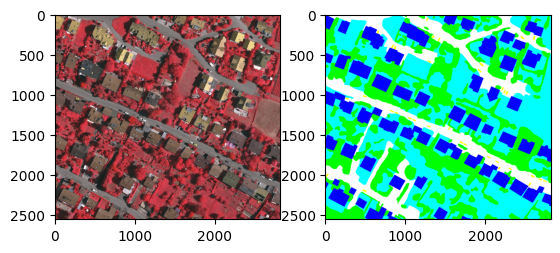

In [7]:
#Ici, on affiche aleatoirement une image et sa verite
indice_img = random.randint(0, len(list_of_files) - 1)
path_img_example = os.path.join(PATH_GOOGLE_DRIVE, FOLDER_IMG, list_of_files[indice_img])
path_gt_example = os.path.join(PATH_GOOGLE_DRIVE, FOLDER_GT, list_of_files[indice_img])
img = plt.imread(path_img_example)
gt = plt.imread(path_gt_example)

#Vous avez ci dessous la methode pour l'affichage des images sur un graphique
f, axarr = plt.subplots(1,2)
axarr[0].imshow(img)
axarr[1].imshow(gt)

print('Dimension de l\'image : ' + str(img.shape))
print('Dimension de la vérité : ' + str(gt.shape))

In [8]:
from random import randrange
#Methode pour générer les patchs d'entrainement et de validation
#Note : attention au typage des données, qui peut, si mal géré, remplir l'espace mémoire rapidement
def generate_learning_patches(path_folder_gt, path_folder_img, nb_patches, size_patches, list_with_filename, data_aug=False):
  #Compteur du nombre d'image
  _current_nb = 0
  #Liste des ptachs images et vérité
  X_res = list()
  Y_res = list()

  #On boucle sur le nombre de patchs créés
  while _current_nb < nb_patches:
    #Index aléatoire pour selectionner un fichier dans les listes
    i = random.randint(0, len(list_with_filename) - 1)
    #On extrait les chemins vers les patchs
    _gt_path = os.path.join(path_folder_gt, list_with_filename[i])
    _img_path = os.path.join(path_folder_img, list_with_filename[i])

    #On lit les patchs verite et image
    _gt = tiff.imread(_gt_path).astype('uint8')
    _img = tiff.imread(_img_path).astype('float16')

    #On choisit des coordonnées aléatoire dans l'image (attention aux bords !)
    _y = random.randint(0, _gt.shape[0] - size_patches)
    _x = random.randint(0, _gt.shape[1] - size_patches)

    #On selectionne les patchs images et verites dans les grandes images
    res_gt = _gt[_y:(_y + size_patches), _x:(_x + size_patches)]
    res_img = _img[_y:(_y + size_patches), _x:(_x + size_patches)]

    #On normalise chacune des bandes en divisant par 255 pour avoir des valeurs comprises entre 0 et 1
    for b in range(0, res_img.shape[2]):
      res_img[:,:,b] = res_img[:,:,b]/255

    #On convertit les patchs vérités
    res_gt = convert_from_color(res_gt)

    #On creer notre matrice zero de profondeur 7 que l'on va remplir par la suite
    _tmp_gt = np.zeros((res_gt.shape[0], res_gt.shape[1], 7), dtype=np.uint8)

    #On boucle sur nos 7 classes (0 à 6) et on binarise avant de l'ajouter à la bande correspondante de notre matrice nulle
    for i in range(0, 7):
      _tmp_gt[:, :, i] = np.where(res_gt == i, 1, 0)

    #Glitch pour économiser de la mémoire
    res_gt = _tmp_gt
    _tmp_gt = None

    #On ajout nos patchs aux listes correspondantes et on convertit avec le meilleur type de données
    X_res.append(res_img.astype(np.float16))
    Y_res.append(res_gt.astype('uint8'))

    #On incrémente notre compteur patch
    _current_nb += 1

    #On applique nos méthodes d'augmentation de données sur notre patch image et vérité
    if data_aug:
      if randrange(100) <= 25:
        res_img, res_gt = data_augmentation(res_img, res_gt)
        X_res.append(res_img.astype(np.float16))
        Y_res.append(res_gt.astype('uint8'))
        _current_nb += 1

  #On renvoie les deux listes que l'on convertit en tenseurs
  return np.array(X_res), np.array(Y_res)

In [ ]:
#Génération des imagettes (patchs) pour l'entrainement et la validation
path_folder_gt = os.path.join(PATH_GOOGLE_DRIVE, FOLDER_GT)
path_folder_img = os.path.join(PATH_GOOGLE_DRIVE, FOLDER_IMG)
nb_patches_valid = 1
nb_patches_train = 12
size_patches = 256

X_train, Y_train = generate_learning_patches(path_folder_gt, path_folder_img, nb_patches_train, size_patches, list_train, data_aug=True)
X_valid, Y_valid = generate_learning_patches(path_folder_gt, path_folder_img, nb_patches_valid, size_patches, list_train, data_aug=False)

## Apprentissage

In [ ]:
model = sm.Unet('vgg16', classes=7, activation='softmax', input_shape=(size_patches, size_patches, 3), encoder_weights='imagenet')

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
PATH_WEIGHTS = 'weights_model.hdf5'

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, min_lr=0.00001)
model_checkpoint = ModelCheckpoint(PATH_WEIGHTS, monitor='val_loss', save_best_only=True)

In [ ]:
model.fit(
   x=X_train,
   y=Y_train,
   batch_size=16,
   epochs=100,
   callbacks = [early_stopping, reduce_lr, model_checkpoint],
   validation_data=(X_valid, Y_valid)
)

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 2.3240 - accuracy: 0.0603

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 34s 34s/step - loss: 2.3240 - accuracy: 0.0603 - val_loss: 5.3571 - val_accuracy: 0.0170 - lr: 0.0010
Epoch 2/100
1/1 [==============================] - 0s 357ms/step - loss: 2.0619 - accuracy: 0.1154 - val_loss: 9.0528 - val_accuracy: 0.0144 - lr: 0.0010
Epoch 3/100
1/1 [==============================] - 0s 350ms/step - loss: 1.8903 - accuracy: 0.1793 - val_loss: 32.3633 - val_accuracy: 0.0058 - lr: 0.0010
Epoch 4/100
1/1 [==============================] - 0s 356ms/step - loss: 1.7292 - accuracy: 0.2658 - val_loss: 42.2476 - val_accuracy: 0.0053 - lr: 0.0010
Epoch 5/100
1/1 [==============================] - 0s 363ms/step - loss: 1.5955 - accuracy: 0.3458 - val_loss: 33.5236 - val_accuracy: 0.0042 - lr: 0.0010
Epoch 6/100
1/1 [==============================] - 0s 368ms/step - loss: 1.4932 - accuracy: 0.4388 - val_loss: 47.5982 - val_accuracy: 0.0042 - lr: 0.0010
Epoch 7/100
1/1 [==============================] - 0s 378ms/step - loss: 1.4075 - acc

## Prédiction

In [ ]:
model.load_weights('/content/drive/MyDrive/ISPRS_semantic_labeling_Vaihingen/weights_model.hdf5')

1/1 [==============================] - 0s 20ms/step


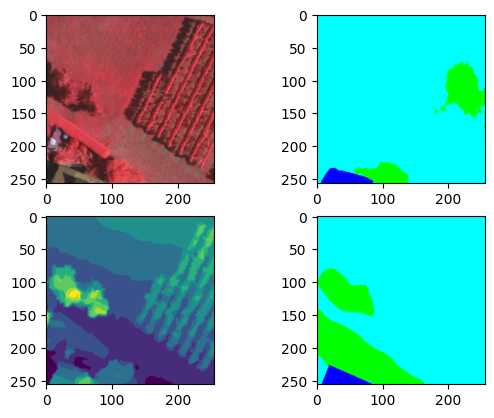

In [ ]:
'''img_m = tiff.imread('/content/drive/MyDrive/ISPRS_semantic_labeling_Vaihingen/top/top_mosaic_09cm_area7.tif').astype(int)
gt = tiff.imread('/content/drive/MyDrive/ISPRS_semantic_labeling_Vaihingen/gts_for_participants/top_mosaic_09cm_area7.tif').astype(int)
dsm = tiff.imread('/content/drive/MyDrive/ISPRS_semantic_labeling_Vaihingen/dsm/dsm_09cm_matching_area7.tif').astype(int)'''

img_m = tiff.imread('/content/drive/MyDrive/ISPRS_semantic_labeling_Vaihingen/top/top_mosaic_09cm_area17.tif').astype(int)
gt = tiff.imread('/content/drive/MyDrive/ISPRS_semantic_labeling_Vaihingen/gts_for_participants/top_mosaic_09cm_area17.tif').astype(int)
dsm = tiff.imread('/content/drive/MyDrive/ISPRS_semantic_labeling_Vaihingen/dsm/dsm_09cm_matching_area17.tif').astype(int)


x = randint(0, img_m.shape[0] - size_patches - 1)
y = randint(0, img_m.shape[1] - size_patches - 1)
pred_test = predict(img_m[x:x+size_patches, y:y+size_patches, :]/255, model, patch_sz=size_patches, n_classes=7)
pred_final = get_prediction_from_mask(pred_test, 7)
res = convert_to_color(pred_final)
img_output = img_m[x:x+size_patches, y:y+size_patches, :]
gt_output = gt[x:x+size_patches, y:y+size_patches, :]
dsm_output = dsm[x:x+size_patches, y:y+size_patches]

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(img_output)
axarr[0,1].imshow(res)
axarr[1,0].imshow(dsm_output)
axarr[1,1].imshow(gt_output)

palette = {0 : (255, 255, 255), # Surface imperméable (blanc)
           1 : (0, 0, 255),     # Batiment (bleus)
           2 : (0, 255, 255),   # Végétation basse (cyan)
           3 : (0, 255, 0),     # Arbre (vert)
           4 : (255, 255, 0),   # Voiture (jaune)
           5 : (255, 0, 0),     # Clutter (rouge)
           6 : (0, 0, 0)}       # Indéfini (noir)

In [ ]:
img_m = tiff.imread('/content/drive/MyDrive/ISPRS_semantic_labeling_Vaihingen/top/top_mosaic_09cm_area17.tif').astype(int)
gt = tiff.imread('/content/drive/MyDrive/ISPRS_semantic_labeling_Vaihingen/gts_for_participants/top_mosaic_09cm_area17.tif').astype(int)

#gt = tiff.imread('/content/drive/MyDrive/ISPRS_semantic_labeling_Vaihingen/gts_for_participants/top_mosaic_09cm_area21.tif').astype(int)
array = np.unique(convert_from_color(gt))
print(array)

size_x = img_m.shape[0]
size_y = img_m.shape[1]
_tmp_x = 0
_tmp_y = 0
y_true = []
y_pred = []

while _tmp_y + size_patches < size_y:
  while _tmp_x + size_patches < size_x:
    _patch = img_m[_tmp_x:(_tmp_x + size_patches), _tmp_y:(_tmp_y+size_patches)]
    _patch_gt = gt[_tmp_x:(_tmp_x + size_patches), _tmp_y:(_tmp_y+size_patches)]

    pred = predict(_patch/255, model, patch_sz=size_patches, n_classes=7)
    pred = get_prediction_from_mask(pred, 7)

    _patch_gt = convert_from_color(_patch_gt)

    y_pred = y_pred + list(pred.flatten())
    y_true = y_true + list(_patch_gt.flatten())

    _tmp_x += size_patches

  _tmp_x = 0
  _tmp_y += size_patches

cm = confusion_matrix(y_true, y_pred)
cr = classification_report(y_true, y_pred)
save_confusion_matrix(cm, [0,1,2,3,4])
print(cr)

[0 1 2 3 4]
1/1 [==============================] - 0s 19ms/step
